<a href="https://colab.research.google.com/github/sankeawthong/Project-1-Lita-Chatbot/blob/main/%5B20241228%5D%20FL-DL%20MLP-LSTM%20on%20NF--ToN-IoT%20with%20early%20stopped.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**FL-DL // MLP-BiLSTM model 10 classes on NF-ToN-IoT with early stopping function**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout, Flatten
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.utils import to_categorical

In [ ]:
# Load dataset
dataset = pd.read_csv("Dataset_NF-ToN-IoT.csv") #10 classes dataset

# Preprocessing: Handle missing values (if any)
dataset = dataset.dropna() # Remove missing values

In [ ]:
dataset

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack,Class
0,63318,443,6,91.00,181,165,2,1,24,327,0,Benign,0
1,57442,15600,17,0.00,63,0,1,0,0,0,0,Benign,0
2,57452,15600,17,0.00,63,0,1,0,0,0,0,Benign,0
3,138,138,17,10.16,472,0,2,0,0,0,0,Benign,0
4,51989,15600,17,0.00,63,0,1,0,0,0,0,Benign,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,443,54560,6,91.00,52,52,1,1,17,15,0,Benign,0
1048571,443,54594,6,91.00,52,52,1,1,17,11,0,Benign,0
1048572,443,54582,6,91.00,52,52,1,1,17,11,0,Benign,0
1048573,443,54592,6,91.00,52,52,1,1,17,11,0,Benign,0


**Data Preprocessing**

In [ ]:
# Encode non-numeric columns (if any)
for column in dataset.columns:
    if dataset[column].dtype == 'object':  # Identify categorical columns
        dataset[column] = LabelEncoder().fit_transform(dataset[column])

# Separate features (X) and target (y)
X = dataset.drop(['Class'], axis=1)  # Assuming 'Class' is the target column
y = dataset['Class']

In [ ]:
print("Original Class Distribution:", np.bincount(y))

Original Class Distribution: [164866  17243 149605  10732 453506   1249 135353    142  15966  99913]


In [ ]:
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
!pip install -U imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 14.5 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.12.4
    Uninstalling imbalanced-learn-0.12.4:
      Successfully uninstalled imbalanced-learn-0.12.4


**Data Balancing utilized SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE
# Balance dataset using SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Verify the balanced dataset distribution
print("Balanced Class Distribution:", np.bincount(y))

Balanced Class Distribution: [453506 453506 453506 453506 453506 453506 453506 453506 453506 453506]


**Split data into 80% Training and 20% Testing**

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y)

**Hybrid MLP-BiLSTM with Early stopping function**

In [ ]:
from keras.regularizers import l2
from keras.layers import Reshape

# Convert target to categorical (one-hot encoding)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Define the hybrid MLP + BiLSTM model with regularization and other techniques to reduce overfitting
def build_hybrid_model(input_shape, num_classes):
    model = Sequential()

    # MLP layers with L2 regularization
    model.add(Dense(128, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))  # Increased dropout
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))

    # Reshape output for LSTM layer (adding a new dimension)
    model.add(Reshape((1, 64)))  # Reshape to (batch_size, timesteps=1, features=64)

    # BiLSTM layer
    model.add(Bidirectional(LSTM(64, return_sequences=False)))
    model.add(Dropout(0.5))

    # Dense layers for final feature extraction
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))

    # Output layer with softmax activation for multi-class classification
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Build and compile the model
input_shape = (X_train.shape[1], )
num_classes = y_train.shape[1]
model = build_hybrid_model(input_shape, num_classes)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Train the model with early stopping
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Before fitting the model, ensure y_train and y_test have the correct shape:
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
assert y_train.shape[1:] == (10,), "y_train shape incorrect"
assert y_test.shape[1:] == (10,), "y_test shape incorrect"

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


y_train shape: (3628048, 10)
y_test shape: (907012, 10)
Epoch 1/50
113377/113377 ━━━━━━━━━━━━━━━━━━━━ 401s 4ms/step - accuracy: 0.8739 - loss: 0.4968 - val_accuracy: 0.9931 - val_loss: 0.1849
Epoch 2/50
113377/113377 ━━━━━━━━━━━━━━━━━━━━ 394s 3ms/step - accuracy: 0.9581 - loss: 0.3003 - val_accuracy: 0.9934 - val_loss: 0.1813
Epoch 3/50
113377/113377 ━━━━━━━━━━━━━━━━━━━━ 382s 3ms/step - accuracy: 0.9609 - loss: 0.2956 - val_accuracy: 0.9950 - val_loss: 0.1762
Epoch 4/50
113377/113377 ━━━━━━━━━━━━━━━━━━━━ 394s 3ms/step - accuracy: 0.9623 - loss: 0.2922 - val_accuracy: 0.9927 - val_loss: 0.1741
Epoch 5/50
113377/113377 ━━━━━━━━━━━━━━━━━━━━ 407s 4ms/step - accuracy: 0.9621 - loss: 0.2949 - val_accuracy: 0.9934 - val_loss: 0.1732
Epoch 6/50
113377/113377 ━━━━━━━━━━━━━━━━━━━━ 407s 4ms/step - accuracy: 0.9626 - loss: 0.2935 - val_accuracy: 0.9931 - val_loss: 0.1786
Epoch 7/50
113377/113377 ━━━━━━━━━━━━━━━━━━━━ 411s 4ms/step - accuracy: 0.9624 - loss: 0.2935 - val_accuracy: 0.9934 - val_loss:

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
# Metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print("Accuracy: {:.10f}".format(accuracy))
print("Precision: {:.10f}".format(precision))
print("Recall: {:.10f}".format(recall))
print("F1-Score: {:.10f}".format(f1))

Accuracy: 0.9997089344
Precision: 0.9997094952
Recall: 0.9997089344
F1-Score: 0.9997089349


In [ ]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print("Accuracy: {:.10f}".format(accuracy))
print("Precision: {:.10f}".format(precision))
print("Recall: {:.10f}".format(recall))
print("F1-Score: {:.10f}".format(f1))

28345/28345 ━━━━━━━━━━━━━━━━━━━━ 51s 2ms/step
Accuracy: 0.9997089344
Precision: 0.9997094952
Recall: 0.9997089344
F1-Score: 0.9997089349


In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[90695     0     6     0     0     0     0     0     0     0]
 [    0 90702     0     0     0     0     0     0     0     0]
 [    1    13 90687     0     0     0     0     0     0     0]
 [    0     0    29 90671     1     0     0     0     0     0]
 [    0     0     0     1 90700     0     0     0     0     0]
 [    0     0     0     0     0 90701     0     0     0     0]
 [    0     0     0     0     0   213 90489     0     0     0]
 [    0     0     0     0     0     0     0 90701     0     0]
 [    0     0     0     0     0     0     0     0 90701     0]
 [    0     0     0     0     0     0     0     0     0 90701]]


In [ ]:
# Detection Rate (Recall for each class)
print("Detection Rates per Class:", recall_score(y_true_classes, y_pred_classes, average=None))

Detection Rates per Class: [0.99993385 1.         0.99984565 0.99966924 0.99998897 1.
 0.99765165 1.         1.         1.        ]


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
# Import roc_curve
from sklearn.metrics import roc_curve # This line imports the roc_curve function
from sklearn.metrics import auc # This line imports the auc function
import matplotlib.pyplot as plt # Import the pyplot module from matplotlib as plt

# After training, calculate ROC curves and AUC for each class
n_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, n_classes))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.10f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")

# Save the plot as a high-resolution image
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.close()

# Calculate and print AUC scores for each class
print("\nAUC Scores for each class:")
for i in range(n_classes):
    print(f"Class {i}: {roc_auc[i]:.10f}")

# Calculate macro-average AUC
macro_roc_auc = np.mean(list(roc_auc.values()))
print(f"\nMacro-average AUC: {macro_roc_auc:.10f}")

<ipython-input-18-abc3f78ee52b>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, n_classes))



AUC Scores for each class:
Class 0: 0.9999851179
Class 1: 0.9999999970
Class 2: 0.9999858697
Class 3: 0.9999604901
Class 4: 1.0000000000
Class 5: 0.9997473471
Class 6: 0.9999854511
Class 7: 1.0000000000
Class 8: 1.0000000000
Class 9: 1.0000000000

Macro-average AUC: 0.9999664273


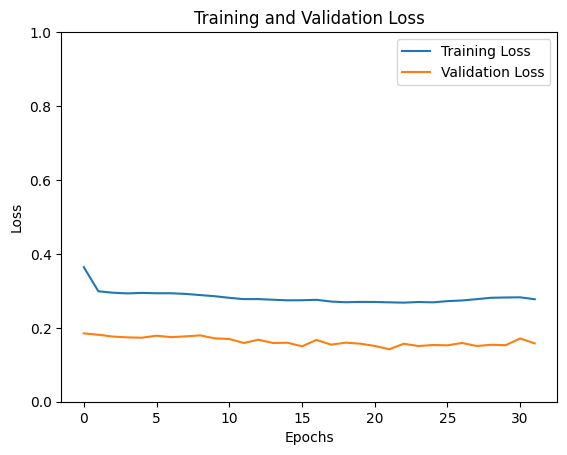

In [ ]:
# Plot Training and Validation Loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)  # Set y-axis scale to 1
plt.legend()
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def conf_mat(d1,d2):
  cm = confusion_matrix(d1, d2)
  #plt.figure(figsize=(6,5.5))
  plt.figure(figsize=(8,6.5))
  #ax = sns.heatmap(cm,  fmt='2', annot=True, cmap='tab20c')
  ax = sns.heatmap(cm, annot=True, fmt=".0f", cmap="PuBu",
                 vmin=0, vmax=35000, center=0, square=True, linewidths=1.5)
  sns.set(font_scale=1)
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values\n');
  ax.xaxis.set_ticklabels(['Benign','Backdoor','DDoS','DoS','Injection','mitm','Password','Ransomware','Scanning','xss'])
  ax.yaxis.set_ticklabels(['Benign','Backdoor','DDoS','DoS','Injection','mitm','Password','Ransomware','Scanning','xss'])
  ##plt.xticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  ##plt.yticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.tight_layout()
  # plt.savefig("F1.eps", format = 'eps')
  plt.show()

Confusion Matrix of Hybrid RF-LSTM Model


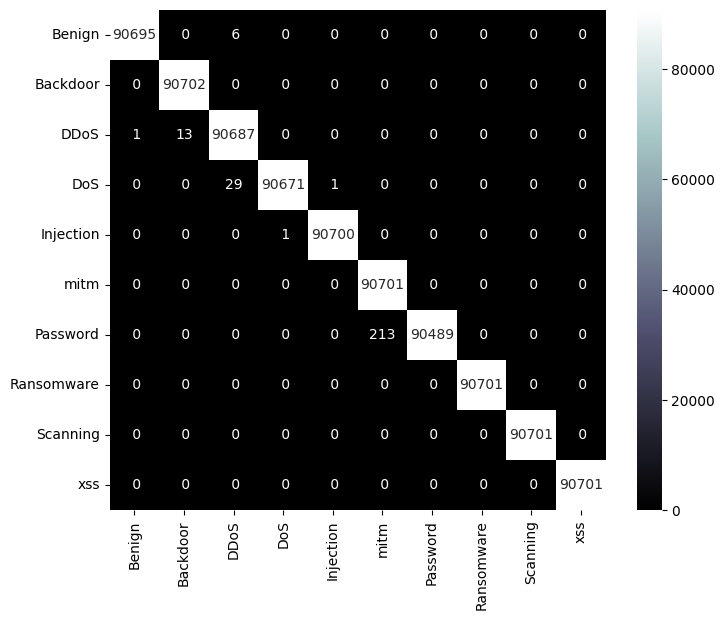

In [ ]:
print("Confusion Matrix of Hybrid RF-LSTM Model")
#conf_mat(np.argmax(y_test, axis=1), test_rf_lstm_predictions)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8,6.5))
# Use plt.xticks to set custom tick labels
# Using get_xticklabels() to access the current labels and then setting rotation.
plt.xticks(ticks=np.arange(10), labels=['Benign','Backdoor','DDoS','DoS','Injection','mitm','Password','Ransomware','Scanning','xss'], rotation=45)
plt.yticks(ticks=np.arange(10), labels=['Benign','Backdoor','DDoS','DoS','Injection','mitm','Password','Ransomware','Scanning','xss'], rotation=45)
sns.heatmap(conf_matrix, annot=True, fmt='2', cmap='bone',xticklabels=['Benign','Backdoor','DDoS','DoS','Injection','mitm','Password','Ransomware','Scanning','xss'], yticklabels=['Benign','Backdoor','DDoS','DoS','Injection','mitm','Password','Ransomware','Scanning','xss'])
sns.set(font_scale=1)
plt.show() # Display the heatmap

In [ ]:
def conf_mat(d1,d2):
  cm = confusion_matrix(y_true_classes, y_pred_classes)
  #plt.figure(figsize=(6,5.5))
  plt.figure(figsize=(8,6.5))
  #ax = sns.heatmap(cm,  fmt='2', annot=True, cmap='tab20c')
  ax = sns.heatmap(cm, annot=True, fmt=".0f", cmap="gist_yarg",
                 vmin=0, vmax=5600, center=0, square=True, linewidths=1.5)
  sns.set(font_scale=0.8)
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values\n');
  ax.xaxis.set_ticklabels(['Benign','Backdoor','DDoS','DoS','Injection','mitm','Password','Ransomware','Scanning','xss'])
  ax.yaxis.set_ticklabels(['Benign','Backdoor','DDoS','DoS','Injection','mitm','Password','Ransomware','Scanning','xss'])
  plt.xticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.yticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.tight_layout()
  # plt.savefig("F1.eps", format = 'eps')
  plt.show()

Confusion Matrix of Federated DL// MLP-LSTM Model


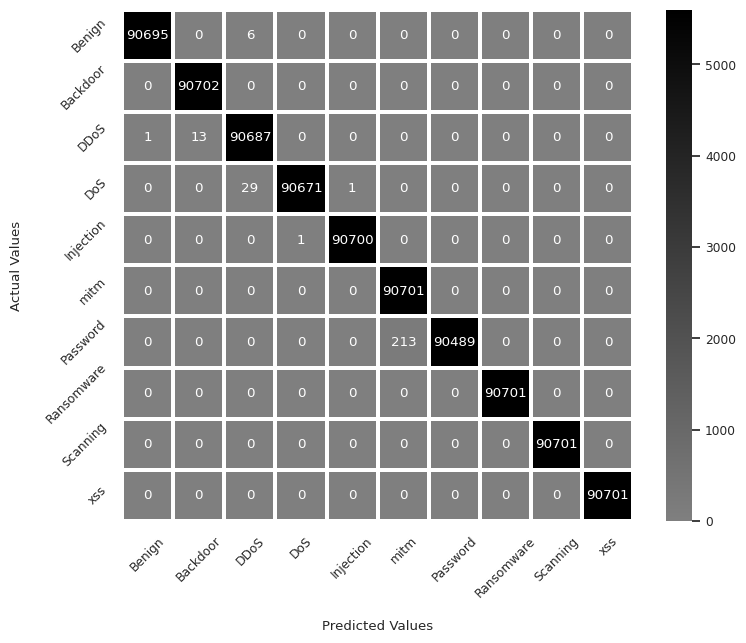

In [ ]:
print("Confusion Matrix of Federated DL// MLP-LSTM Model")
conf_mat(y_true_classes, y_pred_classes)